In [2]:
import sys
import os

project_path = 'c:/Users/Firew Ayele/Desktop/kifiya/telecom_analysis'
sys.path.append(project_path)

import pandas as pd
from Database.db_connection import fetch_data_from_postgres
from src.utils import missing_values_table, convert_bytes_to_megabytes

fetch data from postgres

In [3]:
df =fetch_data_from_postgres()
print(df)

           Bearer Id            Start  Start ms              End  End ms  \
0       1.311448e+19   4/4/2019 12:01     770.0  4/25/2019 14:35   662.0   
1       1.311448e+19   4/9/2019 13:04     235.0   4/25/2019 8:15   606.0   
2       1.311448e+19   4/9/2019 17:42       1.0  4/25/2019 11:58   652.0   
3       1.311448e+19   4/10/2019 0:31     486.0   4/25/2019 7:36   171.0   
4       1.311448e+19  4/12/2019 20:10     565.0  4/25/2019 10:40   954.0   
...              ...              ...       ...              ...     ...   
149996  7.277826e+18   4/29/2019 7:28     451.0   4/30/2019 6:02   214.0   
149997  7.349883e+18   4/29/2019 7:28     483.0  4/30/2019 10:41   187.0   
149998  1.311448e+19   4/29/2019 7:28     283.0  4/30/2019 10:46   810.0   
149999  1.311448e+19   4/29/2019 7:28     696.0  4/30/2019 10:40   327.0   
150000           NaN             None       NaN             None     NaN   

        Dur. (ms)          IMSI  MSISDN/Number          IMEI  \
0       1823652.0  2.08

initial data analysis

In [4]:


missing_values_df = missing_values_table(df)
print("Missing Values in df:")
print(missing_values_df)

Your selected dataframe has 55 columns.
There are 41 columns that have missing values.
Missing Values in df:
                                          Missing Values  % of Total Values  \
Nb of sec with 37500B < Vol UL                    130254               86.8   
Nb of sec with 6250B < Vol UL < 37500B            111843               74.6   
Nb of sec with 125000B < Vol DL                    97538               65.0   
TCP UL Retrans. Vol (Bytes)                        96649               64.4   
Nb of sec with 31250B < Vol DL < 125000B           93586               62.4   
Nb of sec with 1250B < Vol UL < 6250B              92894               61.9   
Nb of sec with 6250B < Vol DL < 31250B             88317               58.9   
TCP DL Retrans. Vol (Bytes)                        88146               58.8   
HTTP UL (Bytes)                                    81810               54.5   
HTTP DL (Bytes)                                    81474               54.3   
Avg RTT DL (ms)       

In [5]:
df['HTTP DL (MB)'] = convert_bytes_to_megabytes(df, 'HTTP DL (Bytes)')

print(df.head())

      Bearer Id            Start  Start ms              End  End ms  \
0  1.311448e+19   4/4/2019 12:01     770.0  4/25/2019 14:35   662.0   
1  1.311448e+19   4/9/2019 13:04     235.0   4/25/2019 8:15   606.0   
2  1.311448e+19   4/9/2019 17:42       1.0  4/25/2019 11:58   652.0   
3  1.311448e+19   4/10/2019 0:31     486.0   4/25/2019 7:36   171.0   
4  1.311448e+19  4/12/2019 20:10     565.0  4/25/2019 10:40   954.0   

   Dur. (ms)          IMSI  MSISDN/Number          IMEI  \
0  1823652.0  2.082014e+14   3.366496e+10  3.552121e+13   
1  1365104.0  2.082019e+14   3.368185e+10  3.579401e+13   
2  1361762.0  2.082003e+14   3.376063e+10  3.528151e+13   
3  1321509.0  2.082014e+14   3.375034e+10  3.535661e+13   
4  1089009.0  2.082014e+14   3.369980e+10  3.540701e+13   

      Last Location Name  ...  Youtube UL (Bytes)  Netflix DL (Bytes)  \
0  9.16456699548519E+015  ...           2501332.0           8198936.0   
1                L77566A  ...          19111729.0          18338413.0   

sessions frequency

In [6]:
# Ensure columns are properly formatted
df['Bearer Id'] = df['Bearer Id'].astype(str)
df['Start'] = pd.to_datetime(df['Start'])
df['End'] = pd.to_datetime(df['End'])

Calculate session frequency per user

In [7]:
user_engagement = df.groupby('Bearer Id').agg(
    session_frequency=('Bearer Id', 'count'),
    total_session_duration=('Dur. (ms)', 'sum'),
    total_DL=('Total DL (Bytes)', 'sum'),
    total_UL=('Total UL (Bytes)', 'sum')
)

Calculate total traffic (DL + UL) for each user


In [8]:
user_engagement['total_traffic'] = user_engagement['total_DL'] + user_engagement['total_UL']


In [9]:
# Reset index to get a clean DataFrame
user_engagement = user_engagement.reset_index()

In [10]:
# Display the user engagement metrics
print(user_engagement.head())

              Bearer Id  session_frequency  total_session_duration  \
0  1.26821377751638e+19                  1                 33510.0   
1  1.26821378067774e+19                  1                 14360.0   
2  1.26821378178156e+19                  1                 14300.0   
3  1.26821378601624e+19                  1                 15642.0   
4  1.26821378872151e+19                  1                 56859.0   

      total_DL    total_UL  total_traffic  
0  511551010.0  41951777.0    553502787.0  
1  873863402.0  46807157.0    920670559.0  
2  612810165.0  45779336.0    658589501.0  
3   89698261.0  56923876.0    146622137.0  
4  381802278.0  58772174.0    440574452.0  


Aggregate Engagement Metrics per Customer (MSISDN)

In [13]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Aggregate metrics per customer (MSISDN)
customer_engagement = df.groupby('MSISDN/Number').agg(
    session_frequency=('Bearer Id', 'count'),
    total_session_duration=('Dur. (ms)', 'sum'),
    total_DL=('Total DL (Bytes)', 'sum'),
    total_UL=('Total UL (Bytes)', 'sum')
)
customer_engagement['total_traffic'] = customer_engagement['total_DL'] + customer_engagement['total_UL']

# Top 10 customers per engagement metric
top_10_frequency = customer_engagement.nlargest(10, 'session_frequency')
top_10_duration = customer_engagement.nlargest(10, 'total_session_duration')
top_10_traffic = customer_engagement.nlargest(10, 'total_traffic')

# Top 10 Customers by Session Frequency
print(top_10_frequency)
# Top 10 Customers by Session Duration
print(top_10_duration)
# Top 10 Customers by Session Total Traffic
print(top_10_traffic)

               session_frequency  total_session_duration      total_DL  \
MSISDN/Number                                                            
3.362632e+10                  18               8791927.0  7.301517e+09   
3.361489e+10                  17               9966898.0  8.156743e+09   
3.362578e+10                  17              18553754.0  7.770043e+09   
3.365973e+10                  16               4035428.0  7.081602e+09   
3.367588e+10                  15               4865947.0  7.309542e+09   
3.376054e+10                  15               9279434.0  7.811295e+09   
3.366716e+10                  13               8744914.0  5.052068e+09   
3.360313e+10                  12               6287761.0  4.540607e+09   
3.360452e+10                  12               5207990.0  5.096079e+09   
3.362708e+10                  12               4703516.0  5.309479e+09   

                  total_UL  total_traffic  
MSISDN/Number                              
3.362632e+10   66965072

 Normalize metrics 

In [15]:

scaler = MinMaxScaler()
normalized_data = scaler.fit_transform(customer_engagement[['session_frequency', 'total_session_duration', 'total_traffic']])
print(normalized_data)

[[0.         0.00590825 0.09593143]
 [0.         0.00938651 0.01402598]
 [0.         0.0068922  0.06385101]
 ...
 [0.         0.04692194 0.02256615]
 [0.         0.01325784 0.06388747]
 [0.         0.04651534 0.0120169 ]]


In [16]:
# Apply K-means with k=3
kmeans = KMeans(n_clusters=3, random_state=42)
customer_engagement['cluster'] = kmeans.fit_predict(normalized_data)

Compute cluster metrics

In [17]:
# Compute the non-normalized metrics for each cluster

cluster_metrics = customer_engagement.groupby('cluster').agg(
    min_session_frequency=('session_frequency', 'min'),
    max_session_frequency=('session_frequency', 'max'),
    avg_session_frequency=('session_frequency', 'mean'),
    total_session_frequency=('session_frequency', 'sum'),
    min_duration=('total_session_duration', 'min'),
    max_duration=('total_session_duration', 'max'),
    avg_duration=('total_session_duration', 'mean'),
    total_duration=('total_session_duration', 'sum'),
    min_traffic=('total_traffic', 'min'),
    max_traffic=('total_traffic', 'max'),
    avg_traffic=('total_traffic', 'mean'),
    total_traffic=('total_traffic', 'sum')
)


In [18]:
print(cluster_metrics)

         min_session_frequency  max_session_frequency  avg_session_frequency  \
cluster                                                                        
0                            2                      4               2.176052   
1                            3                     18               4.248279   
2                            1                      2               1.042226   

         total_session_frequency  min_duration  max_duration   avg_duration  \
cluster                                                                       
0                          47068       18235.0     3174824.0  213600.528202   
1                          17282       46896.0    18553754.0  569329.970747   
2                          84585        7142.0     1573420.0  106984.202543   

         total_duration   min_traffic   max_traffic   avg_traffic  \
cluster                                                             
0          4.620179e+09  2.842182e+08  1.873330e+09  1.125421e+09

 Aggregate user total traffic per application

In [20]:
# Calculate total traffic per application per user
app_traffic_per_user = df.groupby('MSISDN/Number')[['Social Media DL (Bytes)', 'Social Media UL (Bytes)',
                                                    'Google DL (Bytes)', 'Google UL (Bytes)',
                                                    'Email DL (Bytes)', 'Email UL (Bytes)',
                                                    'Youtube DL (Bytes)', 'Youtube UL (Bytes)',
                                                    'Netflix DL (Bytes)', 'Netflix UL (Bytes)',
                                                    'Gaming DL (Bytes)', 'Gaming UL (Bytes)',
                                                    'Other DL (Bytes)', 'Other UL (Bytes)']].sum()

# Summarize total traffic for each application across all users
total_traffic_per_app = app_traffic_per_user.sum()

# Rank users based on total traffic for each application
ranked_users_per_app = app_traffic_per_user.rank(ascending=False, axis=0)

# Select top 10 users with highest total traffic for each application
top_10_users_per_app = {}
for app in app_traffic_per_user.columns:
    top_10_users_per_app[app] = app_traffic_per_user.nlargest(10, app)

# Print the top 10 users per application
for app, top_users in top_10_users_per_app.items():
    print(f"Top 10 users for {app}:")
    print(top_users)
    print("\n")

Top 10 users for Social Media DL (Bytes):
               Social Media DL (Bytes)  Social Media UL (Bytes)  \
MSISDN/Number                                                     
3.362632e+10                42743837.0                 630942.0   
3.376054e+10                39297646.0                 485543.0   
3.365973e+10                34900444.0                 511914.0   
3.361489e+10                27749744.0                 544800.0   
3.362578e+10                26564121.0                 571379.0   
3.366716e+10                23753753.0                 494097.0   
3.378632e+10                23568655.0                 406264.0   
3.366907e+10                23477047.0                 323787.0   
3.360313e+10                22776679.0                 301146.0   
3.365849e+10                22695673.0                 304393.0   

               Google DL (Bytes)  Google UL (Bytes)  Email DL (Bytes)  \
MSISDN/Number                                                           
3.36263

In [21]:
application_engagement = df.groupby('MSISDN/Number').agg(
    social_media_data=('Social Media DL (Bytes)', 'sum'),
    google_data=('Google DL (Bytes)', 'sum'),
    youtube_data=('Youtube DL (Bytes)', 'sum')
)
top_10_social_media = application_engagement.nlargest(10, 'social_media_data')
top_10_google = application_engagement.nlargest(10, 'google_data')
top_10_youtube = application_engagement.nlargest(10, 'youtube_data')


Plot the top 3 most used applications


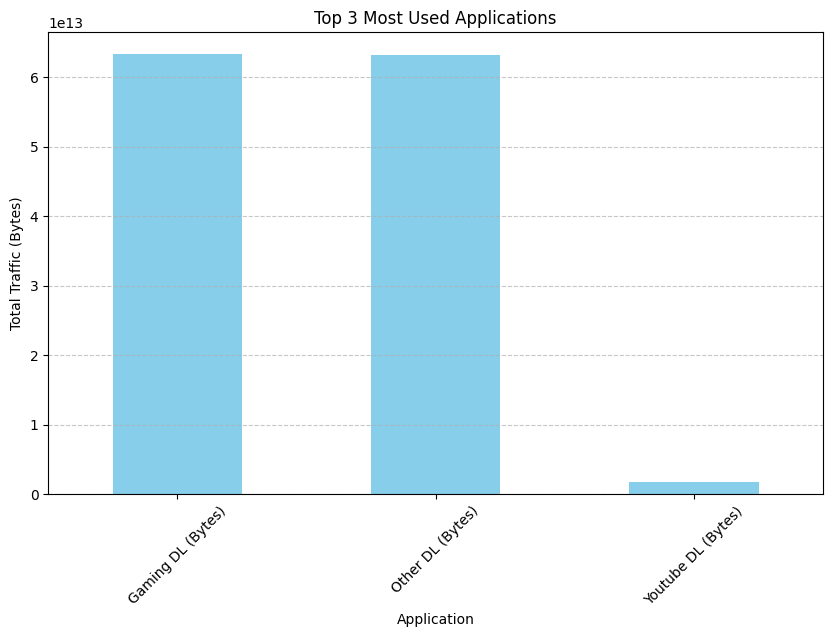

In [34]:
# Calculate the total traffic for each application
total_traffic_per_app = df[['Social Media DL (Bytes)', 'Google DL (Bytes)', 'Email DL (Bytes)',
                            'Youtube DL (Bytes)', 'Netflix DL (Bytes)', 'Gaming DL (Bytes)',
                            'Other DL (Bytes)']].sum()

# Select the top 3 most used applications
top_3_apps = total_traffic_per_app.nlargest(3)

# Plotting
plt.figure(figsize=(10, 6))
top_3_apps.plot(kind='bar', color='skyblue')
plt.title('Top 3 Most Used Applications')
plt.xlabel('Application')
plt.ylabel('Total Traffic (Bytes)')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


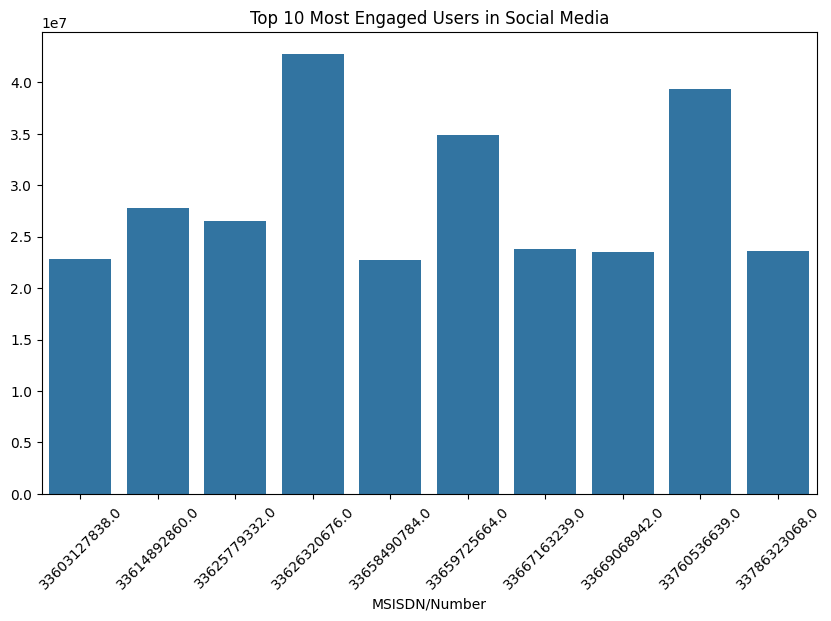

In [35]:
plt.figure(figsize=(10, 6))
sns.barplot(x=top_10_social_media['social_media_data'].index, y=top_10_social_media['social_media_data'].values)
plt.title('Top 10 Most Engaged Users in Social Media')
plt.xticks(rotation=45)
plt.show()